<a href="https://colab.research.google.com/github/gandalf1819/SF-Opioid-Crisis/blob/master/logistic_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from math import ceil
import scipy.stats as stats 
%matplotlib inline

In [0]:
d_crime = pd.read_csv("/content/gdrive/My Drive/SF dataset/Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv")

In [0]:
d_crime.head(3)

<Figure size 720x360 with 0 Axes>

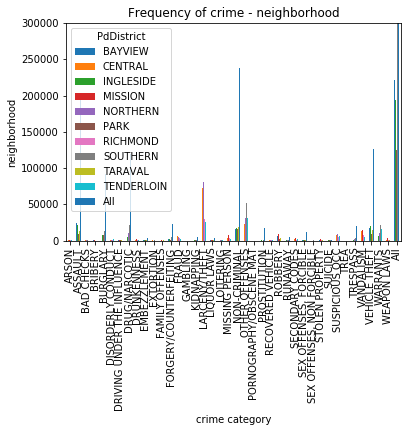

<Figure size 720x360 with 0 Axes>

In [0]:
#examing the frequency of each type of crime occuring in a given day of week
frequency_table = pd.crosstab(d_crime["Category"],d_crime["DayOfWeek"],margins=1)
frequency_table

In [0]:
#visualizing different types of crime happening in different PdDistrict
frequency_table1 = pd.crosstab(d_crime["Category"],d_crime["PdDistrict"],margins=1)
frequency_table1.plot(kind="bar")
plt.title("Frequency of crime - neighborhood")
plt.xlabel("crime category")
plt.ylabel("neighborhood")
plt.ylim(0,300000)

In [0]:
#Exploring resolution and crime types, and found that Narcotic drug crime frequently result in arrested
pd.crosstab(d_crime["Category"],d_crime["Resolution"],margins=1)

Descript,ABANDONMENT OF CHILD,ABORTION,"ACCESS CARD INFORMATION, PUBLICATION OF","ACCESS CARD INFORMATION, THEFT OF",ACCIDENTAL BURNS,ACCIDENTAL LACERATIONS,ACCIDENTAL SHOOTING,ACTS AGAINST PUBLIC TRANSIT,ADVERTISING DISTRIBUTORS PERMIT VIOLATION,"AEROSOL CONTAINER; SALE, PURCHASE OR POSSESSION OF",AFFIXING ADVERTISMENTS TO POLES,"AGGRAVATED ASSAULT OF POLICE OFFICER, SNIPING","AGGRAVATED ASSAULT OF POLICE OFFICER,BODILY FORCE",AGGRAVATED ASSAULT ON POLICE OFFICER WITH A GUN,AGGRAVATED ASSAULT ON POLICE OFFICER WITH A KNIFE,AGGRAVATED ASSAULT WITH A DEADLY WEAPON,AGGRAVATED ASSAULT WITH A GUN,AGGRAVATED ASSAULT WITH A KNIFE,AGGRAVATED ASSAULT WITH BODILY FORCE,AGGRESSIVE SOLICITING,AID OR HARBOR FELON,AIDED CASE,AIDED CASE -PROPERTY FOR DESTRUCTION,"AIDED CASE, DOG BITE","AIDED CASE, INJURED PERSON","AIDED CASE, MENTAL DISTURBED","AIDED CASE, SICK PERSON","ALCOHOLIC BEVERAGE, PROCURING SALE OF","AMMUNITION, POSS. BY PROHIBITED PERSON","ANIMAL, FIGHTING","ANIMAL, WITHOUT PROPER CARE OR ATTENTION",ANNOY OR MOLEST CHILDREN,"ARMOR PENETRATING AMMUNITION, POSSESSION",ARSON,ARSON OF A COMMERCIAL BUILDING,ARSON OF A POLICE BUILDING,ARSON OF A POLICE VEHICLE,ARSON OF A VACANT BUILDING,ARSON OF A VEHICLE,ARSON OF AN INHABITED DWELLING,...,"VEHICLE, DISABLED PLACARD VIOLATION","VEHICLE, RECOVERED, AUTO","VEHICLE, RECOVERED, BUS","VEHICLE, RECOVERED, CAMPER-HOUSE CAR-MOTOR HOME","VEHICLE, RECOVERED, MOBILE HOME-TRAILER","VEHICLE, RECOVERED, MOTORCYCLE","VEHICLE, RECOVERED, OTHER VEHICLE","VEHICLE, RENTAL, FAILURE TO RETURN","VETERAN OR EX-SERVICEMAN, FALSE REPRESENTATION AS",VIN SWITCH,"VIN, ALTER OR REMOVE",VIOLATION OF CALIF UNEMPLOYMENT INSURANCE ACT,VIOLATION OF CIVIL GANG INJUNCTION,VIOLATION OF EMERGENCY PROTECTIVE ORDER,VIOLATION OF FEDERAL STATUTE,VIOLATION OF FIRE CODE,VIOLATION OF MUNICIPAL CODE,VIOLATION OF MUNICIPAL POLICE CODE,VIOLATION OF PARK CODE,VIOLATION OF RESTRAINING ORDER,VIOLATION OF RESTRICTIONS ON A FIREARM TRANSFER,VIOLATION OF STATE LABOR CODE,VIOLATION OF STAY AWAY ORDER,VISITING WHERE DRUGS ARE USED OR SMOKED,WARRANT ARREST,"WEAPON, ASSAULT, POSSESSION, MANUFACTURE, OR SALE","WEAPON, ASSAULT, REGISTRATION OR TRANSFER VIOLATION","WEAPON, DEADLY, CARRYING WITH INTENT TO COMMIT ASSAULT","WEAPON, DEADLY, EXHIBITING TO RESIST ARREST","WEAPON, DEADLY, POSSESSION OF TO VIOLATE 136.1 PC","WEAPON, POSSESS OR BRING OTHER ON SCHOOL GROUNDS","WEAPON, POSSESSING IN PUBLIC BUILDING OR OPEN MEETING","WEAPON, TAKING OR ATTEMPTING TO TAKE FROM PEACE OFFICER",WEAPONS POSSESSION BY JUVENILE SUSPECT,WEARING MASK OR DISGUISE FOR UNLAWFUL PURPOSE,WEARING THE APPAREL OF OPPOSITE SEX TO DECEIVE,WILLFUL CRUELTY TO CHILD,"WIRETAPS, UNAUTHORIZED",YOUTH COURT,All
Category,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ARSON,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1266,173,6,3,78,1476,515,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3931
ASSAULT,0,0,0,0,0,0,0,0,0,0,0,2,391,15,56,16405,2556,6073,12522,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,296,0,0,194694
BAD CHECKS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,925
BRIBERY,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,813
BURGLARY,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,91543
DISORDERLY CONDUCT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10040
DRIVING UNDER THE INFLUENCE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0

In [0]:
#The following test correlation between variables. Specificly how associated 1 variable is to another
#Trying to find the best predictor x for y variable, also checking how independent each x variables are
#This will run a little longer, please be patient
def association_test(column1,column2): #reference https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix
    frequency_matrix = pd.crosstab(column1,column2)
    chi2 = stats.chi2_contingency(frequency_matrix)[0]
    sample_size = frequency_matrix.sum().sum()
    return np.sqrt(chi2/(sample_size*(min(frequency_matrix.shape)-1)))
interested_columns=["Category","Descript","PdDistrict","Resolution","Address","DayOfWeek"]
association_table=pd.DataFrame(index=interested_columns,columns=interested_columns)
for x in range(0,len(interested_columns)):   #loop for each column name 
  for i in range(0,len(interested_columns)):
    if x==i:                                #this is for building the output table, meaning variable A is 1 associated with itself 
      association_table.at[interested_columns[x],interested_columns[i]]=1.0
    else:                                   #test association score, put them in the association table
      scores=association_test(d_crime[interested_columns[x]],d_crime[interested_columns[i]])
      association_table.at[interested_columns[x],interested_columns[i]]=scores
print(association_table)
print("It looks like DayofWeek data aren't very good predictor of Y,this makes sense because crimes occure all the time")
print("Category is highly associated with description")
print("Overall x variables aren't very good predictors of Y")

            Category  Descript PdDistrict Resolution   Address
Category           1  0.992322   0.121316   0.278839  0.217532
Descript    0.992322         1   0.173501   0.377362  0.121085
PdDistrict  0.121316  0.173501          1  0.0816598  0.993779
Resolution  0.278839  0.377362  0.0816598          1   0.21391
Address     0.217532  0.121085   0.993779    0.21391         1


In [0]:
# Select those narcotic crimes, and run correlation test on them see if theres difference 
cat=d_crime[d_crime['Category']=='DRUG/NARCOTIC']
newinterested_columns=["Descript","PdDistrict","Resolution","Address","X","Y"]
association_table2=pd.DataFrame(index=newinterested_columns,columns=newinterested_columns)
for x in range(0,len(newinterested_columns)):
  for i in range(0,len(newinterested_columns)):
    if x==i:
      association_table2.at[newinterested_columns[x],newinterested_columns[i]]=1.0
    else:
      scores2=association_test(cat[newinterested_columns[x]],cat[newinterested_columns[i]])
      association_table2.at[newinterested_columns[x],newinterested_columns[i]]=scores2
print(association_table2)
print("one significance is that the correlation between address and descript raises, so is resolution and address")
print("so it looks like for narcotic relatied crimes, the address is more correlated with resolution")

            Descript PdDistrict Resolution   Address
Descript           1   0.186657   0.156092  0.343304
PdDistrict  0.186657          1  0.0495451  0.993057
Resolution  0.156092  0.0495451          1  0.413896
Address     0.343304   0.993057   0.413896         1
in all the crime cases that involve drugs, comparing to the above association analysis
one significance is that the correlation between address and descript raises, so is resolution and address


Logistic regression

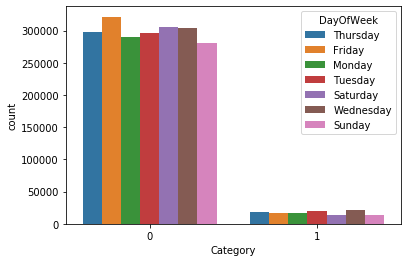

In [0]:
#copy d_crime, make a memo to store True and False, transform non-narcotic crime to 0 and narcotic to 1
log_crime=d_crime.copy()
memo=log_crime['Category']=='DRUG/NARCOTIC'
log_crime["Category"].where(memo,other=np.zeros(shape=len(log_crime),dtype=int),inplace=True)
log_crime["Category"].where(~memo,other=np.ones(shape=len(log_crime),dtype=int),inplace=True)
log_crime["Category"].value_counts()
sns.countplot(x="Category",hue="DayOfWeek",data=log_crime) 
print("For non-narcotic crimes and narcotic ones, there is no a particular day that has more crimes")

In [0]:
#Visualize crimes in terms of non-narcotic vs narcotic, across district
sns.countplot(x="Category",hue="PdDistrict",data=log_crime)
print("Southern has the most of non-narcotic crimes, and Tenderloin has the most of narcotic crimes")

In [0]:
log_crime.head(3)#shows the transformed dataframe

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
0,91092616,0,YOUTH COURT,Thursday,10/15/2009,08:00,NORTHERN,NONE,2200 Block of PACIFIC AV,-122.432295,37.793715,"(37.7937145536167, -122.43229520935)",9109261629130
1,100480883,0,YOUTH COURT,Friday,05/21/2010,13:00,INGLESIDE,NONE,1000 Block of CAYUGA AV,-122.440007,37.721805,"(37.7218048835547, -122.440006611531)",10048088329130
2,80497251,0,YOUTH COURT,Monday,05/12/2008,13:30,MISSION,"ARREST, BOOKED",3700 Block of 18TH ST,-122.427242,37.761412,"(37.7614118083919, -122.427242380192)",8049725129130


In [0]:
#count number of 1s vs 0s
print("There are "+str(log_crime["Category"].value_counts()[0])+ " non-narcotic crimes and "+ str(log_crime["Category"].value_counts()[1]) +" narcotic ones")

0    2095396
1     119628
Name: Category, dtype: int64

In [0]:
#Drop columns that aren't very relavant
#Drop nan 
#create dummy variable representing district so later can trace back
log_crime.drop(["IncidntNum","Descript","DayOfWeek","Date","Time","Resolution","Location","PdId","Address"],axis=1,inplace=True)
log_crime.dropna(inplace=True)
neighborhood=pd.get_dummies(log_crime["PdDistrict"])
log_crime=pd.concat([log_crime,neighborhood],axis=1)
log_crime.drop("PdDistrict",axis=1,inplace=True)
log_crime.head(3)

,Category,X,Y,BAYVIEW,CENTRAL,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN
0,0,-122.432295,37.793715,0,0,0,0,1,0,0,0,0,0
1,0,-122.440007,37.721805,0,0,1,0,0,0,0,0,0,0
2,0,-122.427242,37.761412,0,0,0,1,0,0,0,0,0,0


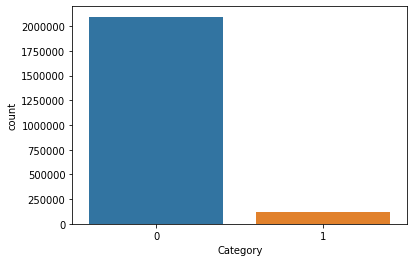

In [0]:
#very imbalanced distribution, minority class is drug related crime. Majority is non-drug crime.
sns.countplot(x="Category",data=log_crime) 

In [0]:
#The initial trial for logistic regreeion
x=log_crime.drop("Category",axis=1)
y=log_crime["Category"]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3)
logreg=LogisticRegression()
y_train=y_train.astype('int')
logreg.fit(x_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1e+30, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
#calculating accuracy score
prediction=logreg.predict(x_test)
y_test=y_test.astype('int')
model_score = accuracy_score(y_test,prediction)
model_score  #too good to be true

[0 0 0 ... 0 0 0]


0.9464324679800212

In [0]:
#print the probability of whether a crime is narcotic related or not, given geo data
proob=logreg.predict_proba(x_test)
print(proob)

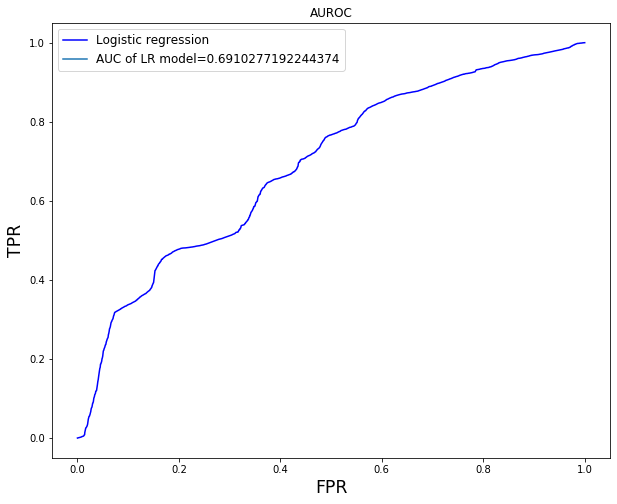

In [0]:
#I made a graph for the first trial of logistic regression
#a 0.68 AUC means the model is 0.68 capable of distinguishing 1s or 0s, not bad but not so good
#still better than 0.5
proob=proob[:,1]
fpr,tpr,thresholds = roc_curve(y_test,proob)
score_log=roc_auc_score(y_test,proob)
plt.figure(figsize=(10,8))                          
plt.title("AUROC")                                 
plt.xlabel("FPR",fontsize="xx-large")              
plt.ylabel("TPR",fontsize="xx-large")
plt.plot(fpr,tpr,color="blue",label="Logistic regression")    
plt.plot([],[],"",label="AUC of LR model="+str(score_log))        
plt.legend(loc="best",fontsize="large")                       
plt.show()

Oversampling to get a more balanced split

In [0]:
#This part starts oversampling, and does transformation first
os_data=d_crime.copy()  #copy d_crime into os_data, this dataframe holds data for oversampling
memo=os_data['Category']=='DRUG/NARCOTIC'    
os_data["Category"].where(memo,other=np.zeros(shape=len(os_data),dtype=int),inplace=True)
os_data["Category"].where(~memo,other=np.ones(shape=len(os_data),dtype=int),inplace=True)
os_data.drop(["IncidntNum","Descript","DayOfWeek","Date","Time","Resolution","Location","PdId","Address"],axis=1,inplace=True)
os_data.dropna(inplace=True)
neighborhood=pd.get_dummies(os_data["PdDistrict"])
os_data=pd.concat([os_data,neighborhood],axis=1) 
os_data.drop("PdDistrict",axis=1,inplace=True) 

In [0]:
from imblearn.over_sampling import SMOTE #import SMOTE from imblearn
#Reference: https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html
os = SMOTE()
x=os_data.drop("Category",axis=1)
y=os_data["Category"]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3) #split first before oversampling
columns=x_train.columns
os_x,os_y = os.fit_sample(x_train,y_train)
os_x = pd.DataFrame(data=os_x,columns=columns)
os_y = pd.DataFrame(data=os_y,columns=['y'])
print("number of non-drug crime is",len(os_y[os_y["y"]==0]))
print("number of drug crime is",len(os_y[os_y["y"]==1]))
print("propotion of of non-drug crime is ",len(os_y[os_y["y"]==0])/len(os_x))
sns.countplot(x="y",data=os_y)

In [0]:
#Now i have a more balanced split, run logistic regression again
logistic_model = LogisticRegression().fit(os_x,os_y.astype(int))
predictt=logistic_model.predict(x_test)
new_result = accuracy_score (y_test.astype(int),predictt)
print(new_result)

In [0]:
#Print the new likelihood of whether a crime is narcotic related or not given geo data
new_prob=logreg.predict_proba(x_test)
output_table = new_prob
print(new_prob)
new_prob=new_prob[:,1]

In [0]:
#Graph the new oversampled LR model
fpr,tpr,thresholds = roc_curve(y_test.astype("int"),new_prob)
score_log=roc_auc_score(y_test.astype("int"),new_prob)
plt.figure(figsize=(10,8))                          
plt.title("AUROC")                                 
plt.xlabel("FPR",fontsize="xx-large")              
plt.ylabel("TPR",fontsize="xx-large")
plt.plot(fpr,tpr,color="blue",label="Logistic regression")    
plt.plot([],[],"",label="AUC of LR model="+str(score_log))        
plt.legend(loc="best",fontsize="large")                       
plt.show()

In [0]:
#Trying to tune the class_weight parameter, see if it can give a better result
logistic_model = LogisticRegression(class_weight='balanced').fit(x_train,y_train.astype(int))
predictt=logistic_model.predict(x_test)
new_result2 = accuracy_score (y_test.astype(int),predictt)
new_result2

In [0]:
#Create an output table, that stores the likelihood
output_table = pd.DataFrame(output_table, columns=["Non-drug_related","drug_related"],index=x_test.index)#set the same index so can trace back

In [0]:
output_table

In [0]:
print("the highest likelihood of a narcotic crime given geo data is " + str(output_table.max()[1]))

In [0]:
#So get the index of rows that have a probability > 0.1 
significant_index = output_table.query("drug_related > 0.10")
significant_index

In [0]:
#make a list 
significant_index = significant_index.index.to_list()

In [0]:
significant_index

In [0]:
#Trace back to the table, so what geo location has higher likelihood of narcotic crimes than others
output_df = x_test.loc[significant_index]
output_df

So based on the analysis and prediction, Tenderloin and its X,Y geo cordinates are most likely to have narcotic crimes happening. If we can build safe injection site and allocate more police resources in that area, we can eliminate narcotic drug distribution and thus help solve the opioid crisis 

Reference lists:
1. https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix

2.https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html